# Setup

Use the steady state frames, used in the paper describing the methods. Also uses roughly the same style in the plots.

In [174]:
steady_states = {
    "uo-050-180-180": [211, 800],
    "uo-060-180-180": [243, 771],
    "uo-070-180-180": [203, 1113],
    "uo-100-180-180": [200, 790],
    "uo-145-180-180": [300, 1097],
    "uo-180-180-070": [500, 1399],
    "uo-180-180-095": [400, 1350],
    "uo-180-180-120": [300, 1099],
    "uo-180-180-180": [400, 1284],
}

style_options = {
    "uo-050-180-180": {"color": "red", "marker": "+"},
    "uo-060-180-180": {"color": "green", "marker": "x"},
    "uo-070-180-180": {"color": "blue", "marker": "x"},
    "uo-100-180-180": {"color": "white", "marker": "s", "edgecolors": "pink"},
    "uo-145-180-180": {"color": "cyan", "marker": "s"},
    "uo-180-180-070": {"color": "grey", "marker": "^"},
    "uo-180-180-095": {"color": "white", "marker": "^", "edgecolors": "orange"},
    "uo-180-180-120": {
        "color": "black",
        "marker": "o",
    },
    "uo-180-180-180": {"color": "white", "marker": "o", "edgecolors": "purple"},
}

## Load trajectories

In [175]:
import pathlib

from pedpy import TrajectoryData, TrajectoryUnit, load_trajectory

folder = pathlib.Path("demo-data/uni-directional")
trajectories = {}
trajectories_in_steady_state = {}
for file in folder.glob("uo*.txt"):
    trajectory = load_trajectory(
        trajectory_file=file,
        default_frame_rate=16.0,
        default_unit=TrajectoryUnit.CENTIMETER,
    )
    trajectory_in_steady_state = TrajectoryData(
        data=trajectory.data[
            trajectory.data.frame.between(
                steady_states[file.stem][0], steady_states[file.stem][1]
            )
        ],
        frame_rate=trajectory.frame_rate,
    )

    trajectories[file.stem] = trajectory
    trajectories_in_steady_state[file.stem] = trajectory_in_steady_state

## Define geometry

In [176]:
from shapely import Polygon

from pedpy import WalkableArea

walkable_area = WalkableArea(
    Polygon(
        [
            (2.8, -6.5),
            (2.8, -4),
            (1.8, -4),
            (1.8, 4),
            (2.8, 4),
            (2.8, 8),
            (-1, 8),
            (-1, 4),
            (0, 4),
            (0, -4),
            (-1, -4),
            (-1, -6.5),
        ]
    )
)

## Define measurement areas

In [177]:
from pedpy import MeasurementArea, MeasurementLine

measurement_area = MeasurementArea([(0, -2.5), (0, 2), (1.8, 2), (1.8, -2.5)])

## Plot trajectories, geometry, and measurement areas/lines

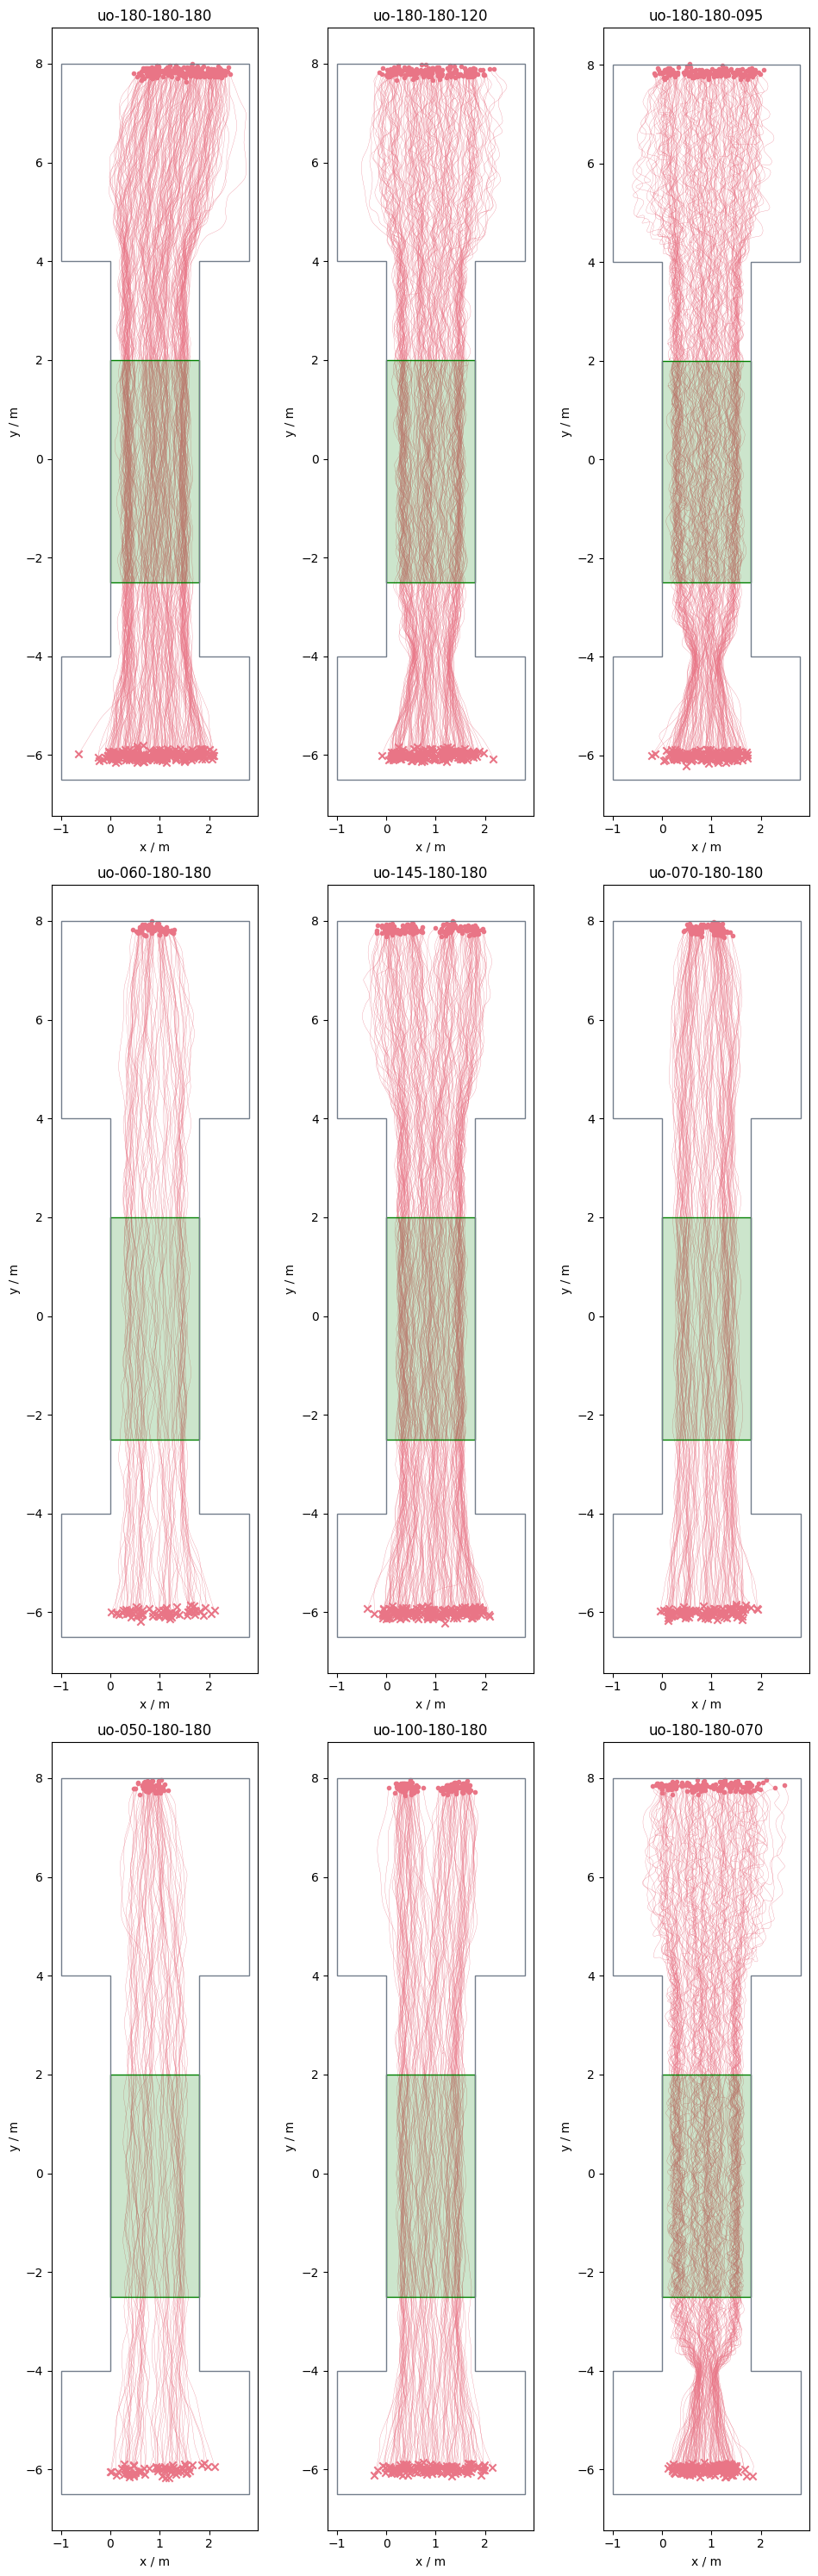

In [178]:
import matplotlib.pyplot as plt

from pedpy import plot_measurement_setup

fig, axs = plt.subplots(3, int(len(trajectories) / 3), figsize=(10, 30))

for (name, trajectory), ax in zip(
    trajectories.items(), axs.ravel(), strict=False
):
    ax.set_title(name)

    ax = plot_measurement_setup(
        traj=trajectory,
        walkable_area=walkable_area,
        measurement_areas=[measurement_area],
        axes=ax,
        traj_width=0.2,
        traj_start_marker=".",
        traj_end_marker="x",
        ma_color="g",
        ma_line_color="g",
        ma_alpha=0.2,
        ml_color="b",
    )
    ax.set_aspect("equal")

fig.tight_layout()
plt.show()

# Short-Time Fourier Transform (STFT)

## Compute the STFT for the sway of one participant

### computation on raw data

In [200]:
from pedpy.column_identifier import *

TrajectoryData_test=trajectories['uo-180-180-070']



In [180]:
# Mockup data for testing
import pandas as pd
import numpy as np
from shapely.geometry import Point

# Define the number of frames
num_frames = 400

# Create the DataFrame
data = []
for id_val in [1, 2]:  # Two unique IDs
    for frame in range(num_frames+500*id_val):
        x = np.cos(2*np.pi*frame / TrajectoryData_test.frame_rate)  # Compute x as cos(frame/16)
        y = np.sin(2*np.pi*frame / TrajectoryData_test.frame_rate)  # Compute y as sin(frame/16)
        point = Point(x, y)  # Create Shapely Point
        
        data.append([id_val, frame, x, y, point])

# Convert to DataFrame
mock_data = pd.DataFrame(data, columns=["id", "frame", "x", "y", "point"])


TrajectoryData_test= TrajectoryData(
        data=mock_data,
        frame_rate=TrajectoryData_test.frame_rate,
    )

In [206]:
from pedpy import compute_STFT

# Group the data by 'id' and apply the STFT function
stft_results = (
    TrajectoryData_test.data.groupby("id")[X_COL]
    .apply(lambda x: compute_STFT(x, 
                                  TrajectoryData_test.frame_rate, 
                                  nperseg=5*TrajectoryData_test.frame_rate, 
                                  noverlap=0.9,
                                  nfft=10*TrajectoryData_test.frame_rate))
)

# Reset index to  makes "id" a column instead of an index.
stft_results = stft_results.reset_index()

### Normalisation of the results

In [207]:
# Find the maximum Time value and its associated id
max_time_row = stft_results.loc[stft_results["Time"].idxmax()]
max_time = max_time_row["Time"]
max_time_id = max_time_row["id"]


# print(f"Max Time: {max_time}, Associated ID: {max_time_id}")

# Determine time resolution of the series for the ID with max Time
max_time_series = stft_results[stft_results["id"] == max_time_id]
time_resolution = np.diff(np.sort(max_time_series["Time"].unique())).min()

# print(f"Time resolution for ID {max_time_id}: {time_resolution}")

In [203]:
# Resample all time series and interpolate missing values
from scipy.interpolate import interp1d

# Create a new uniform time grid for resampling
new_time_grid = np.arange(0, max_time + time_resolution, time_resolution)

# loop over all IDs and frequencies
resampled_data = []
for id_val, group in stft_results.groupby("id"):
    frequencies = group["Frequency"].unique()  # Get unique frequencies

    for freq in frequencies:
        freq_group = group[group["Frequency"] == freq]

        old_time = freq_group["Time"].values
        magnitude = freq_group["Magnitude"].values
        phase = freq_group["Phase"].values

        # Interpolation functions
        interp_magnitude = interp1d(old_time, magnitude, kind="linear", fill_value="extrapolate")
        interp_phase = interp1d(old_time, phase, kind="linear", fill_value="extrapolate")

        # Compute new values at the uniform time grid
        new_magnitude = interp_magnitude(new_time_grid)
        new_phase = interp_phase(new_time_grid)

        # Pad missing values (last valid value)
        last_magnitude = magnitude[-1]
        last_phase = phase[-1]

        new_magnitude[len(old_time):] = last_magnitude
        new_phase[len(old_time):] = last_phase

        # Store resampled data
        for t, mag, ph in zip(new_time_grid, new_magnitude, new_phase):
            resampled_data.append([id_val, freq, t, mag, ph])

# Create a new DataFrame
df_resampled = pd.DataFrame(resampled_data, columns=["id", "Frequency", "Time", "Magnitude", "Phase"])



### Compute the Mean STFT across all participants

In [204]:

# Compute mean Magnitude and Phase for each (Frequency, Time) pair
mean_stft = (
    df_resampled.groupby(["Frequency", "Time"], as_index=False)
    .mean()
)


## Plot the STFT Magnitude Spectrum (provide a plotting function)

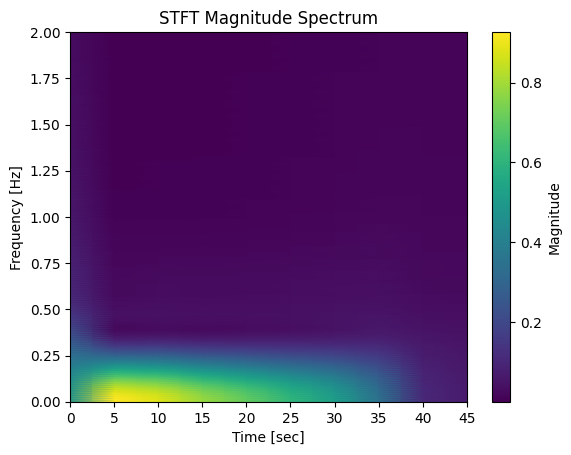

In [205]:
import numpy as np

# Reshape data into 2D arrays for plotting
mag_matrix = mean_stft.pivot(index="Frequency", columns="Time", values="Magnitude").values
plt.pcolormesh(np.array(mean_stft["Time"].unique()),
               np.array(mean_stft["Frequency"].unique()),
               mag_matrix, shading='gouraud')
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 2)
plt.xlabel('Time [sec]')
plt.title('STFT Magnitude Spectrum')
plt.show()

### Computation after feature extraction

Here, we are going to extract the feature of the sway of each participant by substracting a filtered trajectory to the raw trajectory.
We are then going to project this feature on the referential of the filtered trajectory to deal with trajectory changes.
Finally, we will boost the signal using a simple coefficient to increase visibility.